### Project 3 -  Natural Language Processing on Parenting Related Reddit
## Notebook 3/4: Modeling

#### Kristina Joos

Notebook 1: Obtaining Data.  
Notebook 2: Cleaning and Modifying Data.  
Notebook 3: Modeling.  
Notebook 4: Predicting.  

---




# 3. Modeling

---
## 3.1. Importing

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

import itertools


In [35]:
# Reading Traiing Data as d_df:
d_df = pd.read_csv('../data/depression.csv')



---
## 3.2. Defining X and y, Train-Test-Split

### 3.2.1. Defining X and y

In [11]:
X = d_df['doc']
y = d_df['class']

In [12]:
X.shape

(5298,)

In [13]:
d_df['class']

0       1
1       1
2       1
3       1
4       1
       ..
5293    0
5294    0
5295    0
5296    0
5297    0
Name: class, Length: 5298, dtype: int64

### 3.2.2. Train-Test-Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, stratify = y)

In [15]:
y_train.value_counts(normalize=True)

0    0.593254
1    0.406746
Name: class, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.593208
1    0.406792
Name: class, dtype: float64


---
## 3.3. Scoring Function

Custom function to score a model:  
It prints Accuracy of Train and Test Data Set and the ROC AUC.  
It aslo saves the scores to a dictionary (score_dict).  

In [33]:
score_dict={}

def make_scores(gsmodel, model_name):
    
    train_score = gsmodel.score(X_train, y_train)
    test_score = gsmodel.score(X_test, y_test)
    fpr, tpr, thresholds = roc_curve(y_test, gsmodel.predict(X_test), pos_label=1)
    cvect_mnb_AUC = auc(fpr, tpr)
   
    print(f'{model_name} Best Accuracy Training Set: {train_score}')
    
    print(f'{model_name} Best Accuracy Test Set: {test_score}')
    
    print(f'{model_name} ROC AUC: {cvect_mnb_AUC}')
    
    
    score_dict[model_name] = [train_score, test_score, cvect_mnb_AUC]

---
## 3.4. Logistic Regression

__Note:__ I am using the stop words "sleep", "bed" and "night".
Sleep is an important factor in depression, but it parenting groups it is also used in the context of sleeptraining. To correct for this, I am going to exclude this words from the use in the model.

### 3.4.1 CounterVectorizer

In [27]:
# instantiate pipeline

pipe_cvect_logreg = Pipeline([('cvec', CountVectorizer(stop_words = ['sleep', 'bed', 'night'])),
                      ('logreg', LogisticRegression(penalty='l1', C=0.1))])

In [28]:
# pipline parameters 

# I took out the different regex patterns.Choosing an other pattern increased the variance of my results,
# but only increased the train score very little. This is the default pattern CounterVectorizer uses: (r'(?u)\b\w\w+\b').

# I took out the stop_words from the Grid Search. The best model was always the model without stop words.
# I am adding my custom stop words while instantiating the pipeline.

pipe_cvect_logreg_paras = {
    'cvec__max_features': [3000, 2000, 1000],
    #'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range':[(1,1), (1,2)],
    'cvec__min_df': [2,3,4,5],
    'cvec__max_df': [0.8, 0.85, 0.90, 0.95, 0.98],
    #'cvec__token_pattern': [(r'(?u)\b\w+\b'),(r'(?u)\b\w\w+\b'), (r'(?u)\b\w\w\w+\b')]
} 

In [29]:
# grid search

cvect_logreg_gs = GridSearchCV(pipe_cvect_logreg,
                               pipe_cvect_logreg_paras,
                               verbose = 1,
                               cv = 3,
                               n_jobs = 6
                              )

In [30]:
# fit to training set

cvect_logreg_gs.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   59.2s
[Parallel(n_jobs=6)]: Done 360 out of 360 | elapsed:  1.9min finished
/Users/kristina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [36]:
make_scores(cvect_logreg_gs,'CVect/LogReg' )

CVect/LogReg Best Accuracy Training Set: 0.9048577900830607
CVect/LogReg Best Accuracy Test Set: 0.8807547169811321
CVect/LogReg ROC AUC: 0.8671333210591662


### 3.4.2 TFIDFVectorizer

In [37]:
# instantiate pipeline
pipe_tfidf_logreg = Pipeline([('tfidf', TfidfVectorizer(stop_words = ['sleep', 'bed', 'night'])),
                      ('logreg', LogisticRegression(penalty='l1', C=0.1))])

In [38]:
# pipline parameters 

pipe_tfidf_logreg_paras = {
    'tfidf__max_features': [1000, 2000, 3000],
    #'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range':[(1,1), (1,2)],
    'tfidf__min_df': [2,3,4,5],
    'tfidf__max_df': [0.8, 0.85, 0.90, 0.95, 0.98]
}

In [39]:
# grid search

tfidf_logreg_gs = GridSearchCV(pipe_tfidf_logreg,
                               pipe_tfidf_logreg_paras,
                               verbose = 1,
                               cv = 3,
                               n_jobs = 8
                              )

In [40]:
# fit to training set

tfidf_logreg_gs.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   53.7s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  1.8min finished
/Users/kristina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [41]:
make_scores(tfidf_logreg_gs, 'TFIDF/LogReg')

TFIDF/LogReg Best Accuracy Training Set: 0.8223005285678329
TFIDF/LogReg Best Accuracy Test Set: 0.8150943396226416
TFIDF/LogReg ROC AUC: 0.7867198232519933


---
## 3.5. Multinominal Naive Bayes (MNB)

__Note:__ I am using the stop words "sleep", "bed" and "night".
Sleep is an important factor in depression, but it parenting groups it is also used in the context of sleeptraining. To correct for this, I am going to exclude this words from the use in the model.

### 3.5.1 CounterVectorizer

In [42]:
# instantiate pipeline
pipe_cvect_mnb = Pipeline([('cvec', CountVectorizer(stop_words = ['sleep', 'bed', 'night'])),
                      ('mnb', MultinomialNB())])

In [43]:
# pipline parameters 

pipe_cvect_mnb_paras = {
    'cvec__max_features': [1000, 2000, 3000],
    #'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range':[(1,1), (1,2)],
    'cvec__min_df': [2,3,4,5],
    'cvec__max_df': [0.8, 0.85, 0.90],
    'mnb__alpha': [1,5,10]
}

In [44]:
# grid search

cvect_mnb_gs = GridSearchCV(pipe_cvect_mnb,
                               pipe_cvect_mnb_paras,
                               verbose = 1,
                               cv = 3,
                               n_jobs = 8
                              )

In [45]:
# fit to training set

cvect_mnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.0s
/Users/kristina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   51.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 648 out of 648 | elapsed:  3.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [46]:
# Scoring

make_scores(cvect_mnb_gs,'CVect/MNB' )

CVect/MNB Best Accuracy Training Set: 0.8973068210420337
CVect/MNB Best Accuracy Test Set: 0.8905660377358491
CVect/MNB ROC AUC: 0.8978494242943535


### 3.5.2 TFIDFVectorizer

In [47]:
# instantiate pipeline
pipe_tfidf_mnb = Pipeline([('tfidf', TfidfVectorizer(stop_words = ['sleep', 'bed', 'night'])),
                      ('mnb', MultinomialNB(alpha=5))])

In [48]:
# pipline parameters 

pipe_tfidf_mnb_paras = {
    'tfidf__max_features': [1000, 2000, 3000],
    #'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range':[(1,1), (1,2)],
    'tfidf__min_df': [2,3,4,5],
    'tfidf__max_df': [0.8, 0.85, 0.90, 0.95, 0.98],
    'mnb__alpha': [1,5,10]
}

In [49]:
# grid search

tfidf_mnb_gs = GridSearchCV(pipe_tfidf_mnb,
                               pipe_tfidf_mnb_paras,
                               verbose = 1,
                               cv = 3,
                               n_jobs = 8
                              )

In [50]:
# fit to training set

tfidf_mnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.9s
/Users/kristina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   53.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:  5.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [51]:
# scoring

make_scores(tfidf_mnb_gs,'TFIDF/MNB')

TFIDF/MNB Best Accuracy Training Set: 0.9119053611880191
TFIDF/MNB Best Accuracy Test Set: 0.9018867924528302
TFIDF/MNB ROC AUC: 0.9053508287423228


---
## 3.6. Decision Tree

In [52]:
# instantiate pipeline
pipe_tfidf_dt = Pipeline([('tfidf', TfidfVectorizer(stop_words = ['sleep', 'bed', 'night'])),
                      ('dt', DecisionTreeClassifier())])

# pipline parameters 

pipe_tfidft_dt_paras = {
    'tfidf__max_features': [1000, 2000, 3000],
    #'cvec__stop_words': [None, 'english'],
    'tfidf__ngram_range':[(1,1), (1,2)],
    'tfidf__min_df': [3,4,5],
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__use_idf': [True, False], # False == Counter Vectorizer Functionality
    'dt__max_depth': [5,6],
    'dt__min_samples_leaf': [3,4],
    'dt__min_samples_split': [6,7]}


In [53]:
tfidf_dt_gs = GridSearchCV(pipe_tfidf_dt,
                               pipe_tfidft_dt_paras,
                               verbose = 1,
                               cv = 3,
                               n_jobs = -1
                              )

In [54]:
tfidf_dt_gs.fit(X_train, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.9s
/Users/kristina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 10.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [55]:
tfidf_dt_gs.best_params_

{'dt__max_depth': 5,
 'dt__min_samples_leaf': 4,
 'dt__min_samples_split': 7,
 'tfidf__max_df': 0.85,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': True}

In [56]:
# scoring

make_scores(tfidf_dt_gs,'TFIDF/DT')

TFIDF/DT Best Accuracy Training Set: 0.862824062421344
TFIDF/DT Best Accuracy Test Set: 0.8271698113207547
TFIDF/DT ROC AUC: 0.8071008417246148


---
## 3.7. SVN

In [57]:
# instantiate pipeline
pipe_cvect_svc = Pipeline([('cvec', CountVectorizer(stop_words = ['sleep', 'bed', 'night'])),
                      ('svc', SVC())])

# pipline parameters 

pipe_cvect_svc_paras = {
    'cvec__max_features': [3000,5000],
    #'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range':[(1,1), (1,2)],
    'cvec__min_df': [5,6,8],
    'cvec__max_df': [0.75,0.8,0.85, 0.90],
    'svc__kernel':['rbf', 'linear', 'poly'],
    'svc__C': np.logspace(-1, 5, 20),
'svc__gamma': np.logspace(-1, 1, 10)}


In [58]:
pipe_cvect_svc_gs= RandomizedSearchCV(pipe_cvect_svc,
                               pipe_cvect_svc_paras,
                               verbose = 1,
                               cv = 3,
                               n_jobs = -1,
                                      n_iter=20
                              )

In [59]:
pipe_cvect_svc_gs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('cvec',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                          

In [60]:
# scoring

make_scores(pipe_cvect_svc_gs,'CVect/SVN')

CVect/SVN Best Accuracy Training Set: 0.9974830103196577
CVect/SVN Best Accuracy Test Set: 0.8883018867924528
CVect/SVN ROC AUC: 0.8787418506611527


---
## 3.8. Result Overview

### 3.8.1. Base score

In [61]:
y_test.value_counts(normalize=True)

0    0.593208
1    0.406792
Name: class, dtype: float64

The base score is around 60% accuracy.
Meaning, that if a model wourd predict 0 every time, the accuracy would be around 60%.

### 3.8.2. Accuracy Scores

In [62]:
accuracy_df = pd.DataFrame(score_dict, index=['train','test', 'ROC_AUC'])

In [63]:
accuracy_df

,CVect/LogReg,TFIDF/LogReg,CVect/MNB,TFIDF/MNB,TFIDF/DT,CVect/SVN
train,0.904858,0.822301,0.897307,0.911905,0.862824,0.997483
test,0.880755,0.815094,0.890566,0.901887,0.827170,0.888302
ROC_AUC,0.867133,0.786720,0.897849,0.905351,0.807101,0.878742


### 3.8.3. Best Model

In [64]:
accuracy_df[['CVect/MNB','TFIDF/MNB']]

,CVect/MNB,TFIDF/MNB
train,0.897307,0.911905
test,0.890566,0.901887
ROC_AUC,0.897849,0.905351


#### TFIDF/MNB

In [65]:
tfidf_mnb_gs.best_params_

{'mnb__alpha': 5,
 'tfidf__max_df': 0.8,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1)}

#### CVec/MNB

In [66]:
cvect_mnb_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'mnb__alpha': 1}

### 3.8.4. Confusion Matrix best models

Custom function to plot a confusion matrix.

In [67]:
def plot_confusion_matrix(y_pred_i,normalize=False, title='Confusion matrix'):
    
    cm = confusion_matrix(y_test, y_pred_i)
    
    print(cm)
   
    classes = ['not depressed', 'depressed']
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    
    plt.title(title, pad = 12.0, fontsize =12)
    plt.ylabel('True', fontsize =12)
    plt.xlabel('Predicted', fontsize =12)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    middle = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, (cm[i, j]),color="white" if cm[i, j] > middle else "black")
    
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = "{:10.4f}".format(tp/(tp + fn))
    specificity = "{:10.4f}".format(tn/(tn + fp))

    plt.text(2, 0.5,s=f'Sensitivity: {sensitivity}', bbox=dict(facecolor='white', alpha=0.5), fontsize =12)
    plt.text(2, 1,s=f'Specificity: {specificity}', bbox=dict(facecolor='white', alpha=0.5), fontsize =12)
   


#### TFIDF/MNB

In [68]:
y_pred = tfidf_mnb_gs.predict(X_test)

[[697  89]
 [ 41 498]]


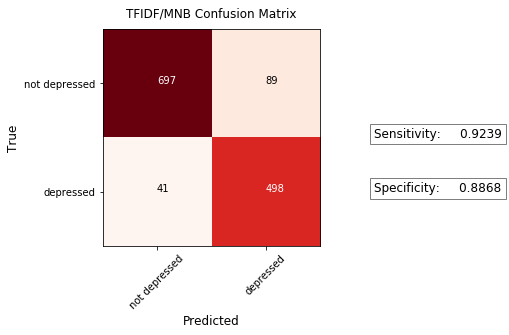

In [69]:
plot_confusion_matrix(y_pred_i
                      =y_pred, title='TFIDF/MNB Confusion Matrix')

#### CVect/MNB

In [70]:
y_pred_2 = cvect_mnb_gs.predict(X_test)

[[675 111]
 [ 34 505]]


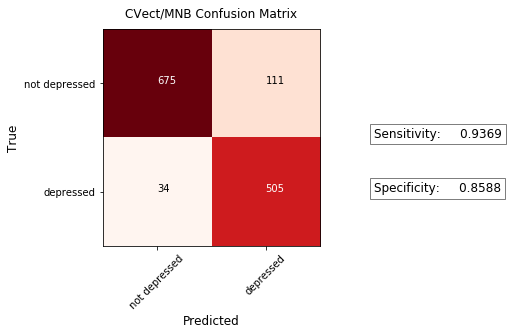

In [71]:
plot_confusion_matrix(y_pred_i
                      =y_pred_2, title='CVect/MNB Confusion Matrix')

### 3.8.5. Choosing model

Even though the performance of TFIDF/MNB is better than CVec/MNB, I am going to use CVec/MNB for prediction.

I choose CVect over TFIDF because I want my model to be interpretable. With CVect, the number of times a word occurs in a document is counted and used for prediction. It is easy to look at the word frequency of the test data. Also, TFIDF weights words, giving words that occur several times in one document but sparsely in the other documents more weight. Since the documents I want to predict are fairly different than the documents I trained the model with (different subreddits), TFIDF is not best approach for what I am doing.


### 3.8.6. Safe best Model and Vectorizer parameters

In [72]:
cvect_mnb_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'mnb__alpha': 1}

In [73]:
used_cvect = CountVectorizer(max_df =0.8,
              max_features = 3000,
              min_df = 3,
              ngram_range = (1, 2),
              stop_words = ['sleep', 'bed', 'night'])
%store used_cvect

Stored 'used_cvect' (CountVectorizer)


In [74]:
fitted_cvect = used_cvect.fit(X_train)
%store fitted_cvect

Stored 'fitted_cvect' (CountVectorizer)


In [75]:
%store cvect_mnb_gs

Stored 'cvect_mnb_gs' (GridSearchCV)
